# Diffusion Models


#### Learning Objectives

The goals of this notebook are to:
* Construct a **forward and reverse diffusion process**
* Make the **U-Net** architecture
* Train a model to detect noise added to an image based on the timestep `t`
* Attempt to generate new images of clothing

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

def save_animation(xs, gif_name, interval=300, repeat_delay=5000):
    fig = plt.figure()
    plt.axis('off')
    imgs = []

    for x_t in xs:
        im = plt.imshow(x_t, animated=True)
        imgs.append([im])

    animate = animation.ArtistAnimation(fig, imgs, interval=interval, repeat_delay=repeat_delay)
    animate.save(gif_name)
#######################################
# Fashion MNIST dataset
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

#######################################

# Number MNIST dataset
def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform,
    )

def load_transformed_MNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    data = ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

#######################################

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.clamp(t, 0, 1)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()), cmap='gray')

def to_image(tensor, to_pil=True):
    tensor = (tensor + 1) / 2
    tensor = torch.clamp(tensor, 0, 1)
    if not to_pil:
        return tensor
    return transforms.functional.to_pil_image(tensor)

def plot_generated_images(noise, result):
    plt.figure(figsize=(8,8))
    nrows = 1
    ncols = 2
    samples = {
        "Noise": noise,
        "Generated Image": result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from IPython.display import Image

# Visualization tools
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image


IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 64
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.81MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Forward Diffusion

Let `T` be the number of times we will add noise to an image. We can use `t` to keep track of the current `timestep`.

We will use a `variance schedule`, represented as $\beta_t$, or `B` in code. This will describe how much noise will be added to our image at each timestep `t`.

In [ ]:
nrows = 10
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)

A [Normal Dsitribution](https://mathworld.wolfram.com/NormalDistribution.html) has the following signature:

$\mathcal{N}(x;u,\sigma^2)$ = $\frac{1}{\sigma\sqrt{2\pi}}\mathcal{e}^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$

which reads as, "the normal distribution of $x$ with parameters $u$ (the mean) and $\sigma^2$ (the variance). When $\mu$ is 0 amd $\sigma$ is 1, we have a standard normal distribution $\mathcal{N}(x;0,1)$, which has the probability density of the shape below:

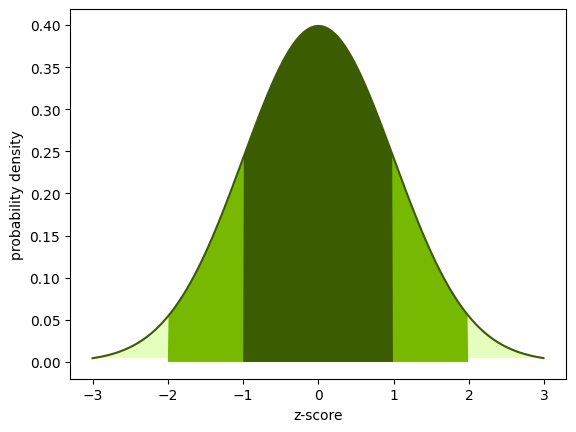

If we are altering our image with noise multiple times accross many timesteps, let's describe $\mathbf{x}_{t}$ as our image at timestep $t$. Then, $\mathbf{x}_{t-1}$ would be the image at the previous timestep and $x_{0}$ would be the original image.

we added noise to images using the equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};(1-\beta_{t}) \cdot \mathbf{x}_{t-1},\beta_{t}^{2}  \cdot \mathbf{I})$

Where $q$ represents a probability distribution for the "forward diffusion process" and $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ describes the probability distribution for a new, noiser image $\mathbf{x}_{t}$ based on $\mathbf{x}_{t-1}$.

This time, we will alter images with the similar equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};\sqrt{1-\beta_{t}} \cdot \mathbf{x}_{t-1},\beta_{t} \cdot \mathbf{I})$

We can sample from this probability distribution by first sampling from a standard normal distribution $\mathcal{N}(x;0,1)$ using torch.randn_like
`noise = torch.randn_like(x_t)`

We can then multiply and add to the noise to sample from `q`:

`x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise`

Let's see all of this in practice. Run the code cell below to perform forward diffusion `T` (we set `150`times step) times on the first image of our dataset.

Contaminated images during T steps


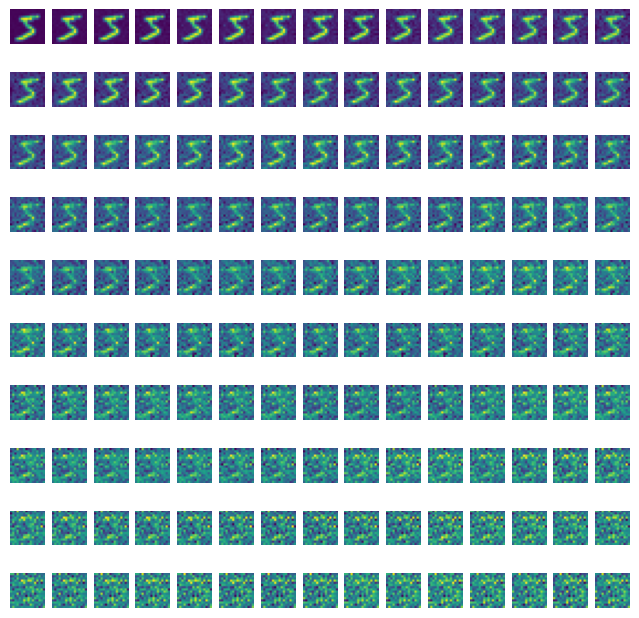

In [ ]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise  # sample from q(x_t|x_t-1)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")
print('Contaminated images during T steps')

In animated form:

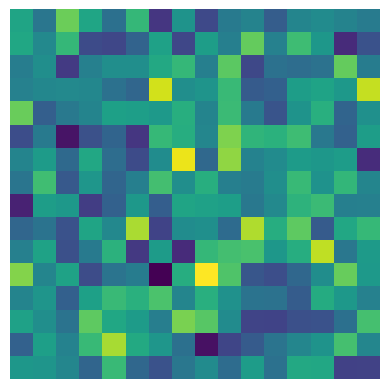

In [ ]:
gif_name = "forward_diffusion.gif"
save_animation(xs, gif_name)

In [ ]:
Image(open(gif_name,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

## Skipping Ahead

We could take each image of our dataset and add noise to them `T` times to create `T` more new images.

Thanks to the power of recursion, we can estimate what $x_t$ would look like given our beta schedule $\beta_t$.
Let's bring back `alpha`, which is the compliment of $\beta$. We can define $\alpha_t$ as $1 - \beta_t$, and we can define $\bar{\alpha}_t$ as the cumulative product of $\alpha_t$.

For example, $\bar{\alpha}_3 = \alpha_0 \cdot \alpha_1 \cdot \alpha_2 \cdot \alpha_3$

Because of the bar symbol, let's call $\bar{\alpha}_t$ `a_bar`. Our new noisy image distribution becomes:

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot x_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

Which translates to code as:

`x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise`

We are now no longer dependent on $\mathbf{x}_{t-1}$ and can estimate $\mathbf{x}_t$ from $x_0$. Let's define these variables in code:

In [ ]:
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient

We have all the pieces, let's code our forward diffusion sampling function `q`:

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot \mathbf{x}_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

Currently, `sqrt_a_bar` and `sqrt_one_minus_a_bar` only have one dimension, and if we index into them with `t`, they will each only have one value. If we want to multiply this value with each of the pixel values in our images, we will need to match the number of dimensions in order to broadcast

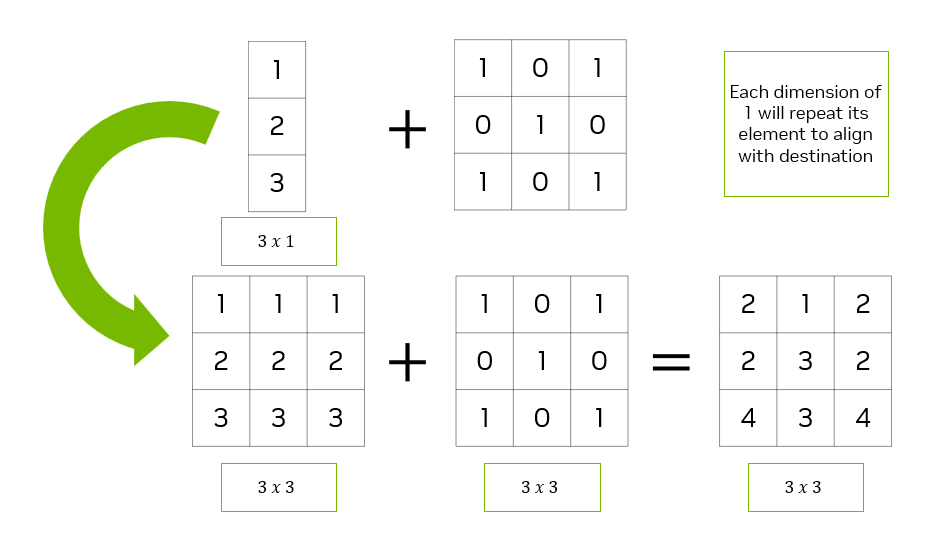

We can add an extra dimension by indexing with `None`. This is a PyTorch shortcut to add an extra dimension to the resulting tensor. For reference, a batch of images has the dimensions: `batch dimension x image channels x image height x image width`.

In [ ]:
def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

Let's test out this new method compared to our old method of recursively generating the images.

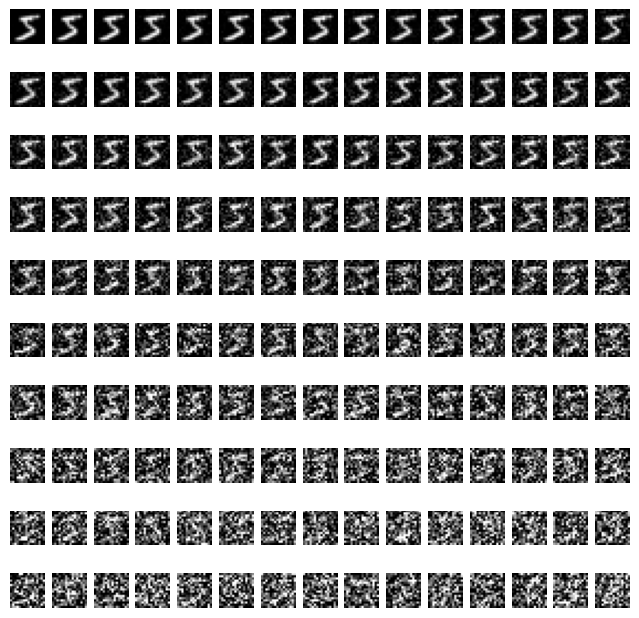

In [ ]:
plt.figure(figsize=(8, 8))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    show_tensor_image(x_t)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')

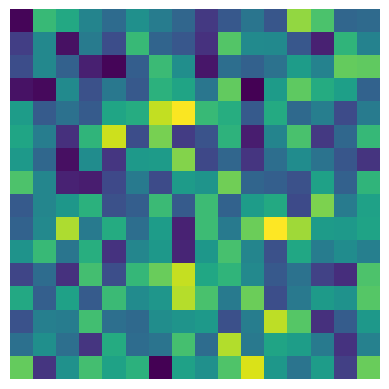

In [ ]:
gif_name = "forward_diffusion_skip.gif"
save_animation(xs, gif_name)

In [ ]:
Image(open(gif_name,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

Compared to the previous technique, can you see any differences? When noise is added sequentially, there is a smaller difference between the images of consecutive timesteps. Despite this, the neural network will do a good job separating the noise from the original image in the reverse diffusion process.

## The U-Net for Predicting Noise

Because the amount of noise added changes with each time step, we will need a way to tell the model which time step our input image is at. $->$ "Time embedding"

To do that, we can create an embedding block like the one below.
* `input_dim` is the number of dimensions of the value we'd like to embed. We'll be embedding `t`, which is a one-dimensional scalar.
* `emb_dim` is the number of dimensions we would like to convert our input value into by using a Linear layer.
* UnFlatten is used to reshape a vector into a multidimensional space. Since we'll be adding the result of this embedding to a multidimensional feature map, we will add a few extra dimensions similar to how we expanded the dimension in the `q` function above.

In [ ]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [ ]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(UNet().to(device))

Num params:  240385


### The Loss Function

We'll compare the real noise that was added to the image and the predicted noise. Originally, the loss function was based on the Evidence Lower Bound (ELBO) Log-Likelihood, but the objective function shurinks into Mean Squared Error between the predicted noise and true noise in practice.

In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

## Reverse Diffusion

We now have a model that predicts the noise added to an image at timestep `t`, but generating images is not as easy as repeatedly subtracting and adding noise. The `q` function can be reversed such that we generate $\mathbf{x}_{t-1}$ from $\mathbf{x}_t$.

$q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t-1};{\mathbf{\tilde{\mu}}}(\mathbf{x_t},\mathbf{x_0}), \tilde{\beta}_t \cdot \mathbf{I})$

**Note**: $\tilde{\beta}_t$ was originally calculated to be $\frac{1-\overline{a}_{t-1}}{1-\overline{a}_{t}}\beta_t$, but in practice, using only $\beta_t$ is more effective.

Using Bayes' Theorem, we can derive an equation for the model_mean `u_t` at timestep `t`.

${\mathbf{\tilde{\mu}}}_t = \frac{1}{\sqrt{\alpha_t}}(\mathbf{x_t}-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha_t}}}\mathbf{\epsilon}_t)$

The image $\mathbf{x}_{t-1}$ can be estimated by ${\mathbf{\tilde{\mu}}}_t + \tilde{\beta}_t \cdot \mathbf{I}$, so we'll use this equation to generate sample images recursively until we reach `t == 0`. Let's see what this means in code. First, we will precompute the values needed to calculate `u_t`.

In [ ]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

Next, we will create the reverse diffusion function, `reverse_q`.

In [ ]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

Let's create a function to iteratively remove noise from an image until it is noise free. Let's also display these images so we can see how the model is improving.

In [ ]:
@torch.no_grad()
def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from random noise:
    x_t = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Time to train the model! How about it? Does it look like the model is learning?

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 10  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
#print("Final sample:")
#sample_images(ncols)

If you squint your eyes, can you make out what the model is generating?

## Sampling

In [ ]:
model.eval()
figsize=(8,8)
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)

# Improving the U-Net

##  Group Normalization and GELU

In [ ]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])

In [ ]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

## Time Embedding

In [ ]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

## Residual connections

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

## U-Net

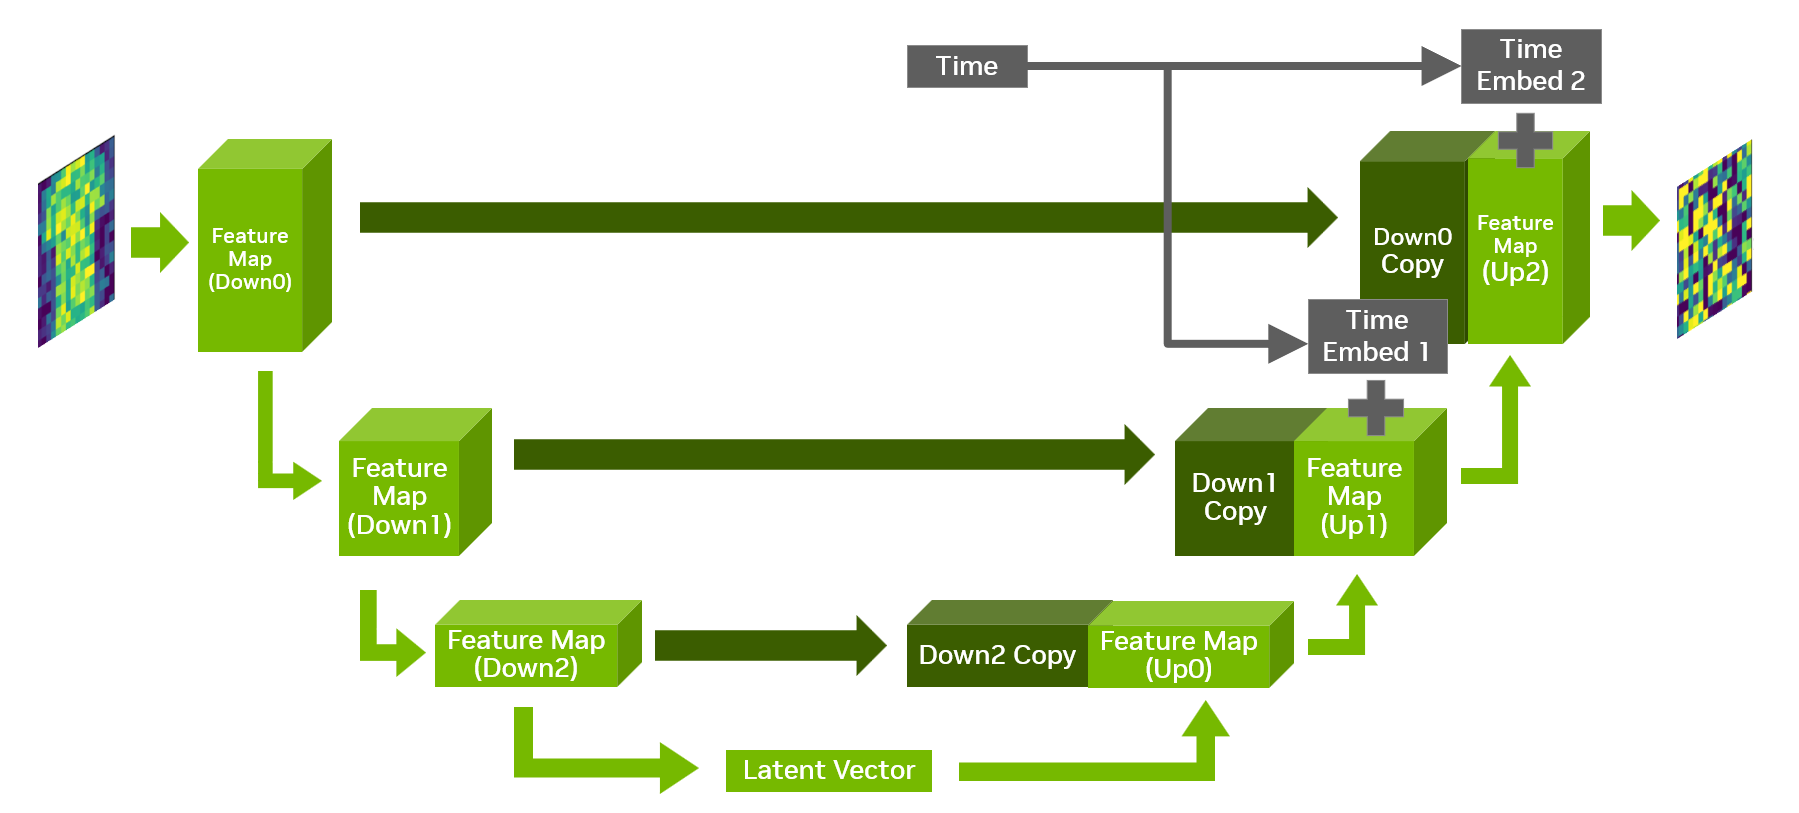

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New


        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

Compare the number of parameter with the previous U-Net

In [ ]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777


In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10
ncols = 10
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_images(ncols)

Output hidden; open in https://colab.research.google.com to view.

## Sampling

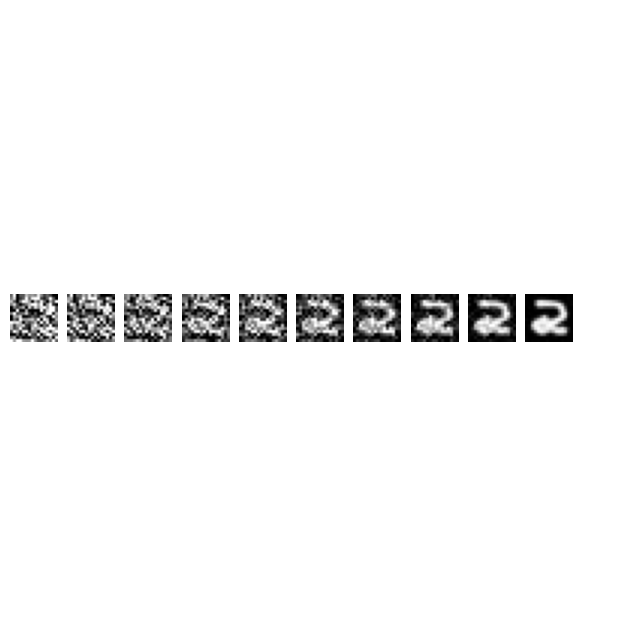

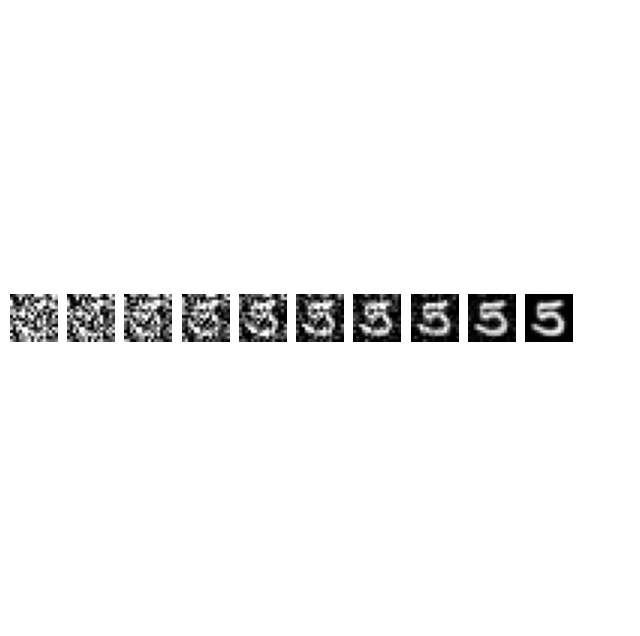

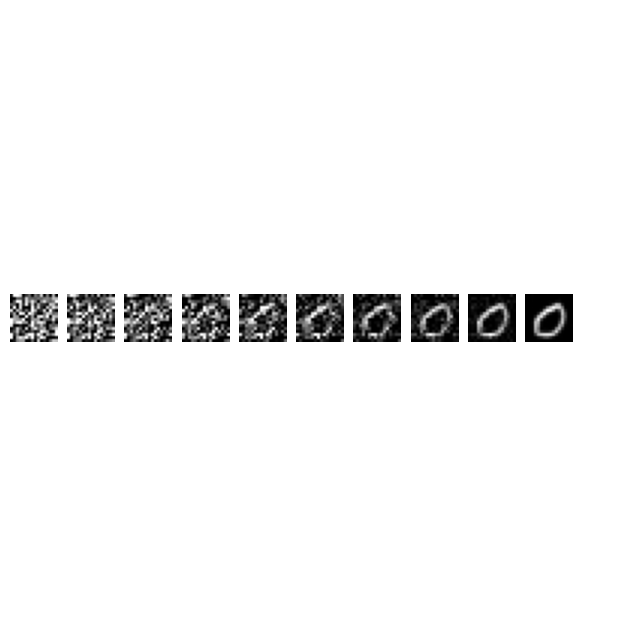

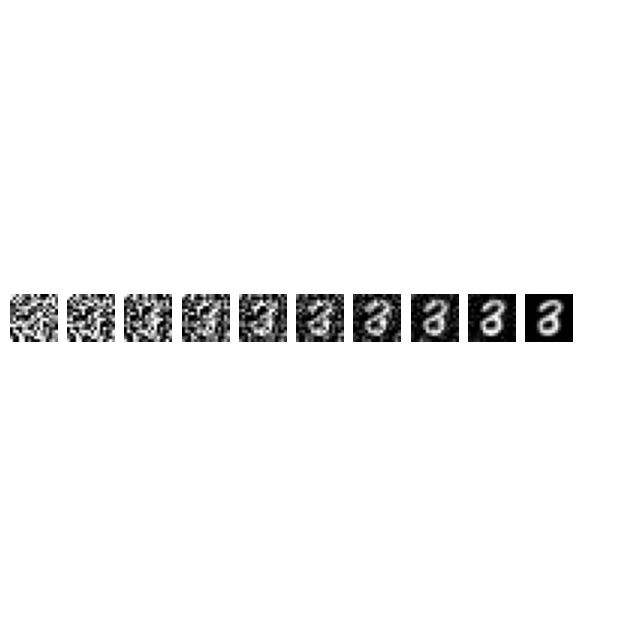

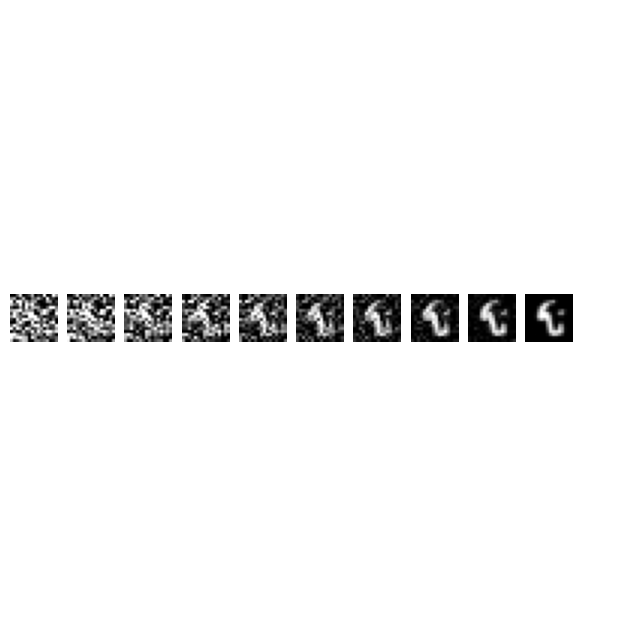

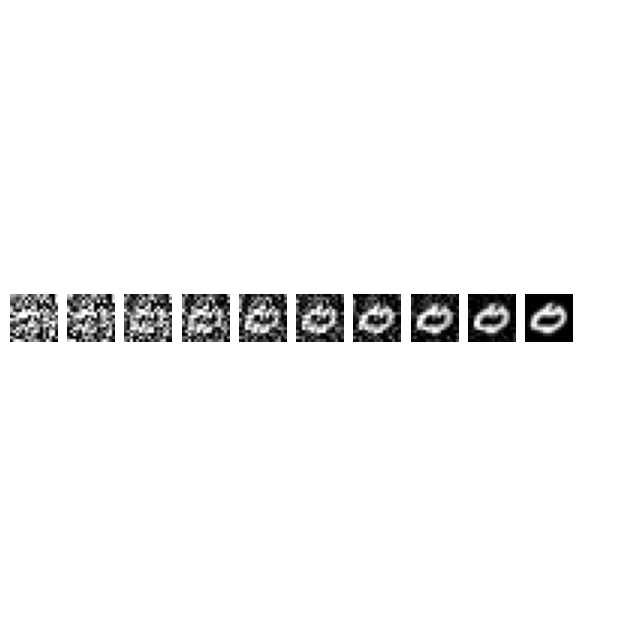

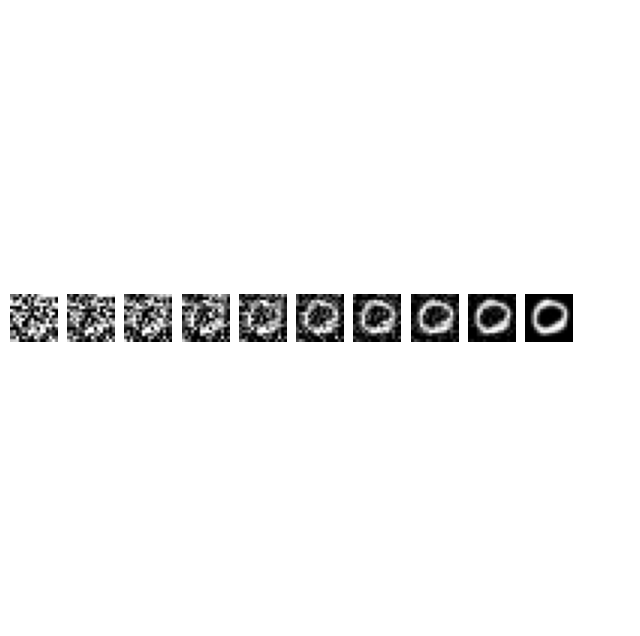

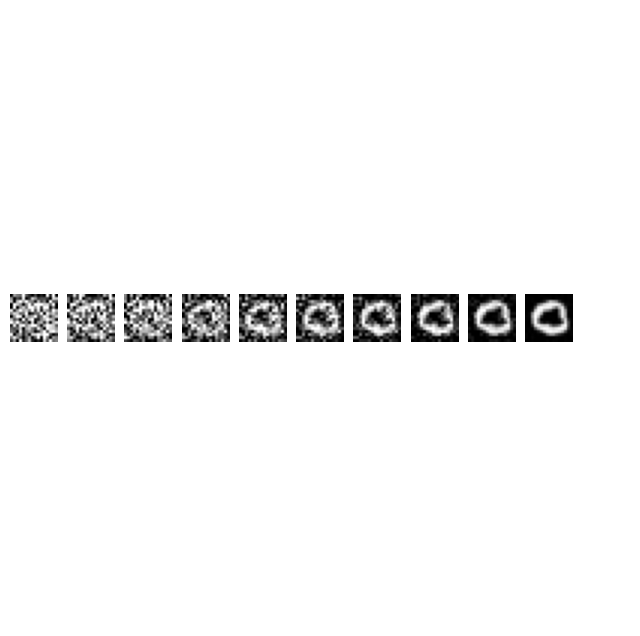

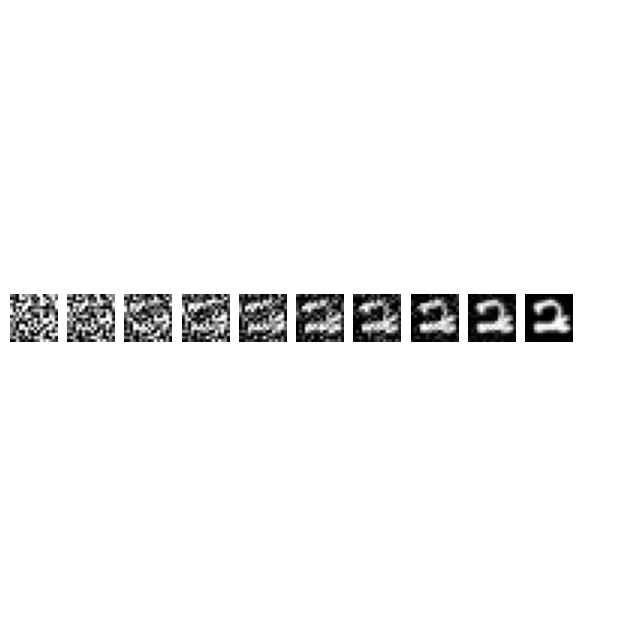

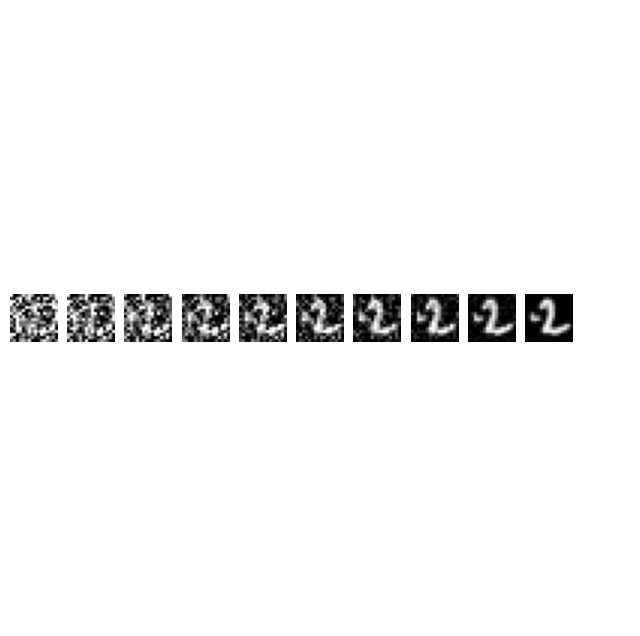

In [ ]:
model.eval()
#plt.figure(figsize=(4,4))
ncols = 10 # Should evenly divide T
for _ in range(10):
    sample_images(ncols)

# Simple Diffusion model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Data generation

def sample2d(data_type, batch_size=200, scale_factor=1.):
    if data_type == '8gaussians':
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1),
                   (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)),
                   (-1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = np.random.randn(2) * 0.5
            idx = np.random.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        dataset *= scale_factor
        return dataset

    elif data_type == '2spirals':
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        x = np.array(x, dtype='float32')
        x *= scale_factor
        return x

    elif data_type == 'checkerboard':
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        dataset = np.concatenate([x1[:, None], x2[:, None]], 1) * 2
        dataset = np.array(dataset, dtype='float32')
        dataset *= scale_factor
        return dataset

    else:
        raise RuntimeError

dataset = '8gaussians'
data_np = sample2d( dataset, batch_size=10000)
data = torch.tensor(data_np, dtype=torch.float32)
dataset = data_utils.TensorDataset(data)
dataloader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
dataset = '8gaussians'
n_timesteps = 1000
T = n_timesteps

start = 0.0001
end = 0.02
B = torch.linspace(start, end, n_timesteps).to(device)

a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)

In [ ]:
def q(x_0, t):
    t = t.long()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t].unsqueeze(1)
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t].unsqueeze(1)
    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def q_sample_progressive(x_0, n_timesteps):
    x_t = x_0
    x_diffused = []
    for t in range(n_timesteps):
        x_t, _ = q(x_0, torch.tensor([t]).to(device))
        x_diffused.append(x_t.cpu().numpy())
    return x_diffused

In [ ]:
x_original = torch.tensor(sample2d(dataset, batch_size=2000)).to(device)
x_diffused = q_sample_progressive(x_original, n_timesteps)

fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
axs[0].scatter(x_original[:,0].cpu(), x_original[:,1].cpu())
axs[0].set_title('t=0 (data)')
axs[0].set_xlim([-4,4])
axs[0].set_ylim([-4,4])

for i_plot, ax in zip([1, 2, 3], axs[1:4]):
    t = n_timesteps // 4 * i_plot
    xx = x_diffused[t - 1]
    ax.scatter(xx[:,0], xx[:,1])
    ax.set_title(f't={t}')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

xx = x_diffused[-1]
axs[4].scatter(xx[:,0], xx[:,1])
axs[4].set_title(f't={n_timesteps} (Should be Gaussian)')
axs[4].set_xlim([-4,4])
axs[4].set_ylim([-4,4])

plt.show()

In [ ]:
class MLP_Diffusion_Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super(MLP_Diffusion_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(-1).float() / T

        # Time embedding
        x = torch.cat([x, t], dim=1)
        return self.net(x)


def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)


@torch.no_grad()
def sample(model, num_samples):
    model.eval()
    x = torch.randn(num_samples, 2).to(device)
    for i in reversed(range(T)):
        t = torch.full((num_samples,), i, device=device, dtype=torch.long)
        e_t = model(x, t)
        a_t = a[t].unsqueeze(1)
        sqrt_a_inv_t = (1. / torch.sqrt(a_t))
        pred_coef = ((1 - a_t) / sqrt_one_minus_a_bar[t].unsqueeze(1))
        x = sqrt_a_inv_t * (x - pred_coef * e_t)
        if i > 0:
            noise = torch.randn_like(x)
            beta_t = B[t].unsqueeze(1)
            x = x + torch.sqrt(beta_t) * noise
    return x.cpu().numpy()

In [ ]:
model = MLP_Diffusion_Model().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 1000

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        x = batch[0].to(device)
        t = torch.randint(0, T, (x.size(0),), device=device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

In [ ]:
samples = sample(model, num_samples=10000)

# original images
plt.figure(figsize=(6, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], alpha=0.5, s=5)
plt.title('Original Data')
plt.show()

# generated images
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=5, color='orange')
plt.title('Generated Samples')
plt.show()

In [ ]:
@torch.no_grad()
def reverse_process(model, num_samples, n_timesteps):

    x_t = torch.randn(num_samples, 2).to(device)
    x_samples = []
    x_samples.append(x_t.cpu().numpy())

    for t in reversed(range(n_timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        e_t = model(x_t, t_tensor)
        a_t = a[t].unsqueeze(0)
        sqrt_a_inv_t = (1. / torch.sqrt(a_t)).unsqueeze(1)
        pred_coef = ((1 - a_t) / sqrt_one_minus_a_bar[t]).unsqueeze(1)
        x_t = sqrt_a_inv_t * (x_t - pred_coef * e_t)
        if t > 0:
            noise = torch.randn_like(x_t)
            beta_t = B[t]
            x_t = x_t + torch.sqrt(beta_t) * noise
        x_samples.append(x_t.cpu().numpy())
    return x_samples

num_samples = 1000
x_samples = reverse_process(model, num_samples, n_timesteps)

fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
axs[0].scatter(x_samples[0][:,0], x_samples[0][:,1], alpha=0.5)
axs[0].set_title(f't={n_timesteps} (Noise)')
axs[0].set_xlim([-4,4])
axs[0].set_ylim([-4,4])

time_steps = [int(n_timesteps * 0.75), int(n_timesteps * 0.5), int(n_timesteps * 0.25), 0]
for i_plot, t in enumerate(time_steps, 1):
    xx = x_samples[n_timesteps - t]
    axs[i_plot].scatter(xx[:,0], xx[:,1], alpha=0.5)
    axs[i_plot].set_title(f't={t}')
    axs[i_plot].set_xlim([-4,4])
    axs[i_plot].set_ylim([-4,4])

plt.show()